In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np

[Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) describes a "two time-scale" model in two equations (2 and 3) which are:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}
(Note that the $F$ term in the top equation is missing in L96 but he provides the parameter and all other authors have it, e.g. [Wilks (2005)](http://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03).)
$X_k$ are the "large scale" variables with $K$ degrees of freedom ($k=0,1,2,\ldots,K-1$, using python indexing starting at $k=0$). The $k$ index is periodic so that, for example, $k=K$ is referring to $k=0$ and $k=-1$ is referring to $k=K-1$. The $j$ indices represent a sub-division of each $k$-element, so that $J$ Y-variables are coupled to a single $X$ variable. When the double-index $j+1,k$ refers to a value beyond $J$, it is cycled to refer to the first value $1,k+1$. The overall structure is illustrated in Fig. 1.


<img src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png" width=400> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale variables ($X_k$) are updated based on neighbouring variables and on the local-scale variables ($Y_{j,k}$) associated with the corresponding global-scale variable. Local-scale variabless are updated based on neighbouring variables and the associated global-scale variable. The neighbourhood topology of both local and global-scale variables is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)*



In [2]:
from L96_model import L96_2t_xdot_ydot
print( inspect.getsource(L96_2t_xdot_ydot) )

@jit
def L96_2t_xdot_ydot(X, Y, F, h, b, c):
    """
    Calculate the time rate of change for the X and Y variables for the Lorenz '96, two time-scale
    model, equations 2 and 3:
        d/dt X[k] =     -X[k-1] ( X[k-2] - X[k+1] )   - X[k] + F - h.c/b sum_j Y[j,k]
        d/dt Y[j] = -b c Y[j+1] ( Y[j+2] - Y[j-1] ) - c Y[j]     + h.c/b X[k]

    Args:
        X : Values of X variables at the current time step
        Y : Values of Y variables at the current time step
        F : Forcing term
        h : coupling coefficient
        b : ratio of amplitudes
        c : time-scale ratio
    Returns:
        dXdt, dYdt : Array of X and Y time tendencies
    """

    JK,K = len(Y),len(X)
    J = JK//K
    assert JK==J*K, "X and Y have incompatible shapes"
    Xdot = np.zeros(K)
    hcb = (h*c)/b

    Ysummed = Y.reshape((K,J)).sum(axis=-1)
    
    Xdot = np.roll(X,1) * ( np.roll(X,-1) - np.roll(X,2) ) - X + F - hcb * Ysummed
#     for k in range(K):
#         Xdot[k] = ( X[(k+1)%K] - X[

In [3]:
from L96_model import integrate_L96_2t
print( inspect.getsource(integrate_L96_2t) )

def integrate_L96_2t(X0, Y0, si, nt, F, h, b, c, t0=0, dt=0.001):
    """
    Integrates forward-in-time the two time-scale Lorenz 1996 model, using the RK4 integration method.
    Returns the full history with nt+1 values starting with initial conditions, X[:,0]=X0 and Y[:,0]=Y0,
    and ending with the final state, X[:,nt+1] and Y[:,nt+1] at time t0+nt*si.
    
    Note the model is intergrated 
    
    Args:
        X0 : Values of X variables at the current time
        Y0 : Values of Y variables at the current time
        si : Sampling time interval
        nt : Number of sample segments (results in nt+1 samples incl. initial state)
        F  : Forcing term
        h  : coupling coefficient
        b  : ratio of amplitudes
        c  : time-scale ratio
        t0 : Initial time (defaults to 0)
        dt : The actual time step. If dt<si, then si is used. Otherwise si/dt must be a whole number. Default 0.001.

    Returns:
        X[:,:], Y[:,:], time[:] : the full history X[n,k]

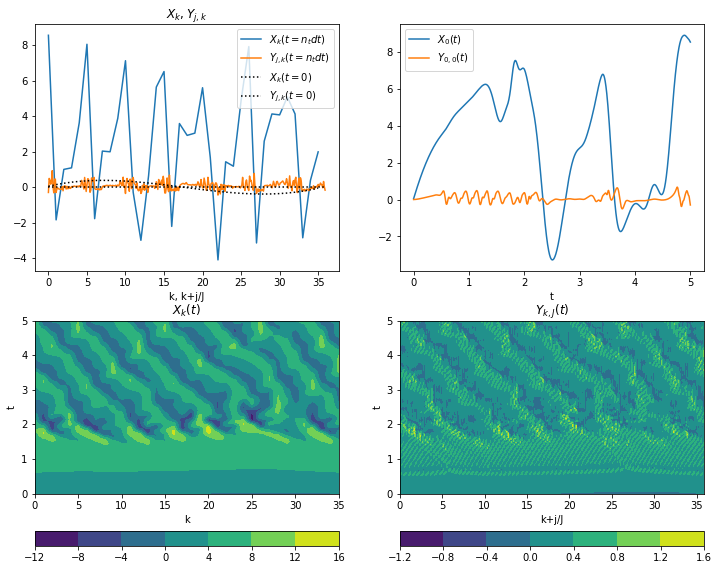

In [4]:
J = 10 # Number of local-scale Y variables per single global-scale X variable
K = 36 # Number of globa-scale variables X
nt = 1000 # Number of time steps
si = 0.005 # Sampling time interval
dt = 0.005 # Time step
F = 10. # Focring
h = 1.0 # Coupling coefficient
b = 10.0 # ratio of amplitudes
c = 10.0 # time-scale ratio

def s(k,K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * ( 0.5 + k ) / K - 1
k = np.arange(K) # For coordinate in plots
j = np.arange(J*K) # For coordinate in plots
# Initial conditions
Xinit = s(k,K)*(s(k,K)-1)*(s(k,K)+1)
Yinit = 0*s(j,J*K)*(s(j,J*K)-1)*(s(j,J*K)+1)

# "Run" model
X,Y,t = integrate_L96_2t(Xinit, Yinit, si, nt, F, h, b, c, dt=dt)

plt.figure(figsize=(12,10))
plt.subplot(221); # Snapshot of X[k]
plt.plot(k, X[-1], label='$X_k(t=n_t dt)$');
plt.plot(j/J, Y[-1], label='$Y_{j,k}(t=n_t dt)$')
plt.plot(k, Xinit, 'k:', label='$X_k(t=0)$');
plt.plot(j/J, Yinit, 'k:', label='$Y_{j,k}(t=0)$')
plt.legend(); plt.xlabel('k, k+j/J'); plt.title('$X_k, Y_{j,k}$');
plt.subplot(222); # Sample time-series X[0](t), Y[0](t)
plt.plot(t, X[:,0], label='$X_0(t)$');
plt.plot(t, Y[:,0], label='$Y_{0,0}(t)$')
plt.legend(); plt.xlabel('t'); 
plt.subplot(223); # Full model history of X
plt.contourf(k,t,X); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$X_k(t)$');
plt.subplot(224); # Full model history of Y
plt.contourf(j/J,t,Y); plt.colorbar(orientation='horizontal'); plt.xlabel('k+j/J'); plt.ylabel('t'); plt.title('$Y_{k,J}(t)$');





In [5]:
from L96_model import L96

help(L96)

Help on class L96 in module L96_model:

class L96(builtins.object)
 |  L96(K, J, F=18, h=1, b=10, c=10, t=0, dt=0.001)
 |  
 |  Class for two time-scale Lorenz 1996 model
 |  
 |  Methods defined here:
 |  
 |  __init__(self, K, J, F=18, h=1, b=10, c=10, t=0, dt=0.001)
 |      Construct a two time-scale model with parameters:
 |      K  : Number of X values
 |      J  : Number of Y values per X value
 |      F  : Forcing term (default 18.)
 |      h  : coupling coefficient (default 1.)
 |      b  : ratio of amplitudes (default 10.)
 |      c  : time-scale ratio (default 10.)
 |      t  : Initial time (default 0.)
 |      dt : Time step (default 0.001)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  copy(self)
 |  
 |  print(self)
 |  
 |  randomize_IC(self)
 |      Randomize the initial conditions (or current state)
 |  
 |  run(self, si, T, store=False)
 |      Run model for a total time of T, sampling at intervals of si.
 |

In [6]:
# Create an instance of the L96 model, default parameters except those given
M = L96(36, 10, F=10, dt=0.005)
M

L96: K=36 J=10 F=10 h=1 b=10 c=10 dt=0.005

In [7]:
# Set the initial conditions (here X is the same cubic as above, Y=0)
M.set_state(s(M.k,M.K)*(s(M.k,M.K)-1)*(s(M.k,M.K)+1), 0*M.j)
print(M)

L96: K=36 J=10 F=10 h=1 b=10 c=10 dt=0.005
 X=[ 0.05326217  0.14641204  0.22258659  0.28281464  0.328125    0.35954647
  0.37810785  0.38483796  0.3807656   0.36691958  0.3443287   0.31402178
  0.27702761  0.234375    0.18709276  0.13620971  0.08275463  0.02775634
 -0.02775634 -0.08275463 -0.13620971 -0.18709276 -0.234375   -0.27702761
 -0.31402178 -0.3443287  -0.36691958 -0.3807656  -0.38483796 -0.37810785
 -0.35954647 -0.328125   -0.28281464 -0.22258659 -0.14641204 -0.05326217]
 Y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [8]:
# Run the model for 1000 sample intervals, or for time 1000*0.005 = 5
X2,Y2,t = M.run(0.005, 5)

print('Mean absolute difference =',np.abs(X2-X).mean() + np.abs(Y2-Y).mean() )

Mean absolute difference = 0.0


In [9]:
# The one line version of the above
X3,Y3,t = L96(36, 10, F=10, dt=0.005).set_state(s(M.k,M.K)*(s(M.k,M.K)-1)*(s(M.k,M.K)+1), 0*M.j).run(0.005, 5)

print('Mean absolute difference =',np.abs(X3-X).mean() + np.abs(Y3-Y).mean() )

Mean absolute difference = 0.0
